In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [77]:
import timm
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import math
import pickle
import PIL.Image
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
from statistics import mean
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset, random_split

from tqdm import tqdm
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform
from timm.data import create_loader

from shared_interest.datasets.imagenet import ImageNet
from shared_interest.shared_interest import shared_interest
from shared_interest.util import flatten, binarize_std, normalize_0to1
from interpretability_methods.vanilla_gradients import VanillaGradients
from interpretability_methods.gradcam import GradCAM
from interpretability_methods.util import visualize_saliency

import matplotlib.patches as mpatches
from torchvision.datasets import CIFAR100
from sklearn.linear_model import LogisticRegression

In [4]:
# list of 195 models
models = ['adv_inception_v3', 'bat_resnext26ts', 'beit_base_patch16_224', 'beit_base_patch16_384', 'botnet26t_256', 'cait_s24_224', 'cait_s24_384', 'cait_s36_384', 'cait_xs24_384', 'cait_xxs24_224', 'cait_xxs24_384', 'cait_xxs36_224', 'cait_xxs36_384', 'coat_lite_mini', 'coat_lite_small', 'coat_lite_tiny', 'coat_mini', 'coat_tiny', 'convit_base', 'convit_small', 'convit_tiny', 'convmixer_1024_20_ks9_p14', 'convnext_base', 'cspdarknet53', 'cspresnet50', 'cspresnext50', 'deit_base_patch16_224', 'densenet121', 'dla60', 'dla60_res2net', 'dla60_res2next', 'dla60x', 'dla60x_c', 'dm_nfnet_f2', 'dpn68', 'efficientnetv2_rw_t', 'ens_adv_inception_resnet_v2', 'ese_vovnet19b_dw', 'ese_vovnet39b', 'fbnetc_100', 'fbnetv3_d', 'fbnetv3_g', 'gc_efficientnetv2_rw_t', 'gcresnet33ts', 'gcresnet50t', 'gcresnext26ts', 'gcresnext50ts', 'gernet_l', 'gernet_m', 'gernet_s', 'ghostnet_100', 'gluon_inception_v3', 'gluon_resnet101_v1b', 'gluon_resnet152_v1b', 'gluon_resnet152_v1c', 'gluon_resnet152_v1d', 'gluon_resnet152_v1s', 'gluon_resnet18_v1b', 'gluon_resnet34_v1b', 'gluon_resnet50_v1b', 'gluon_resnet50_v1c', 'gluon_resnet50_v1d', 'gluon_resnet50_v1s', 'gluon_resnext101_32x4d', 'gluon_senet154', 'gluon_seresnext101_32x4d', 'gmixer_24_224', 'gmlp_s16_224', 'halo2botnet50ts_256', 'halonet26t', 'haloregnetz_b', 'hardcorenas_a', 'hrnet_w18', 'ig_resnext101_32x16d', 'inception_resnet_v2', 'inception_v3', 'jx_nest_base', 'lambda_resnet26rpt_256', 'lamhalobotnet50ts_256', 'lcnet_050', 'legacy_senet154', 'legacy_seresnet101', 'legacy_seresnext101_32x4d', 'mixer_b16_224', 'mixnet_l', 'mnasnet_100', 'regnety_080', 'regnety_120', 'regnety_160', 'regnety_320', 'regnetz_b16', 'regnetz_c16', 'regnetz_d32', 'regnetz_d8', 'regnetz_e8', 'repvgg_a2', 'repvgg_b0', 'repvgg_b1', 'repvgg_b1g4', 'repvgg_b2', 'repvgg_b2g4', 'repvgg_b3', 'repvgg_b3g4', 'res2net101_26w_4s', 'res2net50_14w_8s', 'res2net50_26w_4s', 'res2net50_26w_6s', 'res2net50_26w_8s', 'res2net50_48w_2s', 'res2next50', 'resmlp_12_224', 'resmlp_12_distilled_224', 'resmlp_24_224', 'resmlp_24_distilled_224', 'resmlp_36_224', 'resmlp_36_distilled_224', 'resmlp_big_24_224', 'resmlp_big_24_224_in22ft1k', 'resmlp_big_24_distilled_224', 'resnest101e', 'resnest14d', 'resnest200e', 'resnest269e', 'resnest26d', 'resnest50d', 'resnest50d_1s4x24d', 'resnest50d_4s2x40d', 'resnet101', 'resnet101d', 'resnet152', 'resnet152d', 'resnet18', 'resnet18d', 'resnet200d', 'resnet26', 'resnet26d', 'resnet26t', 'resnet32ts', 'resnet33ts', 'resnet34', 'resnext26ts', 'resnext50_32x4d', 'sebotnet33ts_256', 'sehalonet33ts', 'selecsls60b', 'semnasnet_075', 'semnasnet_100', 'seresnet152d', 'seresnet33ts', 'seresnet50', 'seresnext26d_32x4d', 'seresnext26t_32x4d', 'seresnext26ts', 'seresnext50_32x4d', 'skresnet18', 'skresnet34', 'skresnext50_32x4d', 'spnasnet_100', 'ssl_resnet18', 'ssl_resnet50', 'ssl_resnext101_32x16d', 'ssl_resnext101_32x4d', 'ssl_resnext101_32x8d', 'ssl_resnext50_32x4d', 'swin_base_patch4_window12_384', 'swin_base_patch4_window7_224', 'swsl_resnet18', 'swsl_resnext101_32x4d', 'swsl_resnext101_32x8d', 'swsl_resnext50_32x4d', 'tf_efficientnet_b0', 'tf_efficientnet_b0_ap', 'tf_efficientnet_b0_ns', 'tf_efficientnet_b1', 'tf_efficientnet_b1_ap', 'tf_efficientnet_b1_ns', 'tf_efficientnet_b2', 'tf_efficientnet_b2_ap', 'tf_efficientnet_b2_ns', 'tf_efficientnet_b3', 'tf_efficientnet_b3_ap', 'tf_efficientnet_b3_ns', 'tf_efficientnet_b4', 'tf_inception_v3', 'tf_mixnet_s', 'tf_mobilenetv3_small_minimal_100', 'tinynet_a', 'tnt_s_patch16_224', 'tv_resnet50', 'tv_resnext50_32x4d', 'twins_pcpvt_base', 'twins_svt_base', 'vgg16', 'vgg16_bn', 'visformer_small']

In [5]:
# dividing models by architecture type
cnn_models = ['adv_inception_v3', 'bat_resnext26ts', 'convmixer_1024_20_ks9_p14', 'convnext_base', 'cspdarknet53', 'cspresnet50', 'cspresnext50', 'densenet121', 'dla60', 'dla60_res2net', 'dla60_res2next', 'dla60x', 'dla60x_c', 'dm_nfnet_f2', 'dpn68', 'efficientnetv2_rw_t', 'ens_adv_inception_resnet_v2', 'ese_vovnet19b_dw', 'ese_vovnet39b', 'fbnetc_100', 'fbnetv3_d', 'fbnetv3_g', 'gc_efficientnetv2_rw_t', 'gcresnet33ts', 'gcresnet50t', 'gcresnext26ts', 'gcresnext50ts', 'gernet_l', 'gernet_m', 'gernet_s', 'ghostnet_100', 'gluon_inception_v3', 'gluon_resnet101_v1b', 'gluon_resnet152_v1b', 'gluon_resnet152_v1c', 'gluon_resnet152_v1d', 'gluon_resnet152_v1s', 'gluon_resnet18_v1b', 'gluon_resnet34_v1b', 'gluon_resnet50_v1b', 'gluon_resnet50_v1c', 'gluon_resnet50_v1d', 'gluon_resnet50_v1s', 'gluon_resnext101_32x4d', 'gluon_senet154', 'gluon_seresnext101_32x4d', 'hrnet_w18', 'ig_resnext101_32x16d', 'inception_resnet_v2', 'inception_v3', 'lcnet_050', 'legacy_senet154', 'legacy_seresnet101', 'legacy_seresnext101_32x4d', 'mixnet_l', 'mnasnet_100', 'regnety_080', 'regnety_120', 'regnety_160', 'regnety_320', 'regnetz_b16', 'regnetz_c16', 'regnetz_d32', 'regnetz_d8', 'regnetz_e8', 'repvgg_a2', 'repvgg_b0', 'repvgg_b1', 'repvgg_b1g4', 'repvgg_b2', 'repvgg_b2g4', 'repvgg_b3', 'repvgg_b3g4', 'res2net101_26w_4s', 'res2net50_14w_8s', 'res2net50_26w_4s', 'res2net50_26w_6s', 'res2net50_26w_8s', 'res2net50_48w_2s', 'res2next50', 'resnest101e', 'resnest14d', 'resnest200e', 'resnest269e', 'resnest26d', 'resnest50d', 'resnest50d_1s4x24d', 'resnest50d_4s2x40d', 'resnet101', 'resnet101d', 'resnet152', 'resnet152d', 'resnet18', 'resnet18d', 'resnet200d', 'resnet26', 'resnet26d', 'resnet26t', 'resnet32ts', 'resnet33ts', 'resnet34', 'resnext26ts', 'resnext50_32x4d', 'sebotnet33ts_256', 'sehalonet33ts', 'selecsls60b', 'semnasnet_075', 'semnasnet_100', 'seresnet152d', 'seresnet33ts', 'seresnet50', 'seresnext26d_32x4d', 'seresnext26t_32x4d', 'seresnext26ts', 'seresnext50_32x4d', 'skresnet18', 'skresnet34', 'skresnext50_32x4d', 'spnasnet_100', 'ssl_resnet18', 'ssl_resnet50', 'ssl_resnext101_32x16d', 'ssl_resnext101_32x4d', 'ssl_resnext101_32x8d', 'ssl_resnext50_32x4d', 'swsl_resnet18', 'swsl_resnext101_32x4d', 'swsl_resnext101_32x8d', 'swsl_resnext50_32x4d', 'tf_efficientnet_b0', 'tf_efficientnet_b0_ap', 'tf_efficientnet_b0_ns', 'tf_efficientnet_b1', 'tf_efficientnet_b1_ap', 'tf_efficientnet_b1_ns', 'tf_efficientnet_b2', 'tf_efficientnet_b2_ap', 'tf_efficientnet_b2_ns', 'tf_efficientnet_b3', 'tf_efficientnet_b3_ap', 'tf_efficientnet_b3_ns', 'tf_efficientnet_b4', 'tf_inception_v3', 'tf_mixnet_s', 'tf_mobilenetv3_small_minimal_100', 'tinynet_a', 'tv_resnet50', 'tv_resnext50_32x4d', 'vgg16', 'vgg16_bn']
transformer_models = ['beit_base_patch16_224', 'beit_base_patch16_384', 'cait_s24_224', 'cait_s24_384', 'cait_s36_384', 'cait_xs24_384', 'cait_xxs24_224', 'cait_xxs24_384', 'cait_xxs36_224', 'cait_xxs36_384', 'coat_lite_mini', 'coat_lite_small', 'coat_lite_tiny', 'coat_mini', 'coat_tiny', 'deit_base_patch16_224', 'gmlp_s16_224', 'mixer_b16_224', 'resmlp_12_224', 'resmlp_12_distilled_224', 'resmlp_24_224', 'resmlp_24_distilled_224', 'resmlp_36_224', 'resmlp_36_distilled_224', 'resmlp_big_24_224', 'resmlp_big_24_224_in22ft1k', 'resmlp_big_24_distilled_224', 'swin_base_patch4_window12_384', 'swin_base_patch4_window7_224', 'tnt_s_patch16_224', 'twins_pcpvt_base', 'twins_svt_base', 'visformer_small']
other_models = ['botnet26t_256', 'convit_base', 'convit_small', 'convit_tiny', 'gmixer_24_224', 'halo2botnet50ts_256', 'halonet26t', 'haloregnetz_b', 'hardcorenas_a', 'jx_nest_base', 'lambda_resnet26rpt_256', 'lamhalobotnet50ts_256']

In [66]:
# extracting embeddings 

def get_embeddings(dataset, model):
    loader = DataLoader(dataset, batch_size=64, shuffle=False)
    features = []
    labels = []
    
    with torch.no_grad():
        for images, targets in loader:
            images = images.to(device)
            outputs = model(images)
            features.append(outputs.cpu())
            labels.extend(targets)

    return torch.cat(features).numpy(), np.array(labels)

In [71]:
cifar_transform = transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224),
                                transforms.ToTensor(), transforms.Normalize(mean=[0.5071, 0.4867, 0.4408], std=[0.2675, 0.2565, 0.2761])])

cifar_dir = '' # TODO: add your cifar directory here.
cifar_dataset = CIFAR100(cifar_dir,train=False,transform=cifar_transform)

n = 1
n_shot_indices = []
test_indices = []

for cls in range(100):  # CIFAR100 has 100 classes
    indices = np.where(np.array(dataset.targets) == cls)[0]
    np.random.shuffle(indices)
    n_shot_indices.extend(indices[:n])
    test_indices.extend(indices[n:])

cifar_train = Subset(cifar_dataset, n_shot_indices)
cifar_test = Subset(cifar_dataset, test_indices)

In [7]:
imagenet_dir = '' # TODO: add your imagenet directory here.
image_dir = os.path.join(imagenet_dir, 'images')
annotation_dir = os.path.join(imagenet_dir, 'annotations')

In [8]:
# ImageNet transforms.
image_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                           std=[0.229, 0.224, 0.225]),
                                     ])

ground_truth_transform = transforms.Compose([transforms.ToPILImage(),
                                             transforms.Resize(256, PIL.Image.NEAREST),
                                             transforms.CenterCrop(224),
                                             transforms.ToTensor()])

reverse_image_transform = transforms.Compose([transforms.Normalize(mean=[0, 0, 0], 
                                                                   std=[4.3668, 4.4643, 4.4444]),
                                              transforms.Normalize(mean=[-0.485, -0.456, -0.406], 
                                                                   std=[1, 1, 1]),
                                              transforms.ToPILImage(),])

In [9]:
dataset = ImageNet(image_dir, annotation_dir, image_transform, ground_truth_transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=False, 
                                         num_workers=40, pin_memory=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0


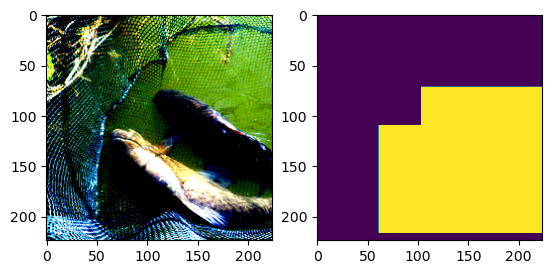

In [10]:
for image, ground_truth, label in dataset:
    print (PIL.Image.NEAREST)
    fig, ax = plt.subplots(nrows=1, ncols=2)
    ax[0].imshow(image.permute(1, 2, 0))
    ax[1].imshow(ground_truth)
    break

In [11]:
def get_last_conv_layer_name(model):
    last_conv_layer_name = None
    last_conv_layer = None
    for name, layer in model.named_modules():
        if isinstance(layer, nn.Conv2d):
            last_conv_layer_name = name
            last_conv_layer = layer
    return last_conv_layer

def binarize_threshold(batch, threshold):
    batch_normalized = normalize_0to1(batch)
    binary_mask = (batch_normalized >= threshold).astype('uint8')
    return binary_mask

In [79]:
def run_cifar(model, train_subset, test_subset):
    # Get embeddings
    train_embeddings, train_labels = get_embeddings(train_subset, model)
    test_embeddings, test_labels = get_embeddings(test_subset, model)

    # Train logistic regression
    classifier = LogisticRegression(max_iter=1000)
    classifier.fit(train_embeddings, train_labels)

    # Evaluate
    test_accuracy = classifier.score(test_embeddings, test_labels)
    print(f'1-shot accuracy: {test_accuracy * 100:.2f}%')

    return test_accuracy

def run_imagenet(model, dataloader):
    gradcam = GradCAM(model, get_last_conv_layer_name(model))
    vg = VanillaGradients(model)
    
    model.eval()
    accuracy = 0
    total_gradcam_iou = np.array([])
    total_vg_iou = np.array([])
    
    salient_pixel_count = 0

    for i, (images, ground_truth, labels) in enumerate(tqdm(dataloader)):
        with torch.no_grad():
            images = images.to(device)
            ground_truth = ground_truth.numpy()
            labels = labels.numpy()

            # Compute model predictions
            output = model(images)
            predictions = torch.argmax(output, dim=1).detach().cpu().numpy()

            # Update metrics
            accuracy += accuracy_score(labels, predictions)
        
        # Compute GradCAM saliency masks
        gradcam_saliency_masks = binarize_threshold(flatten(gradcam.get_saliency(images)), 0.5)
        
        # Compute Vanilla Gradients saliency
        vg_saliency = flatten(vg.get_saliency(images))
        vg_saliency_masks = binarize_std(vg_saliency)

        # Compute Shared Interest scores
        gradcam_iou = shared_interest(ground_truth, gradcam_saliency_masks, score='iou_coverage')
        total_gradcam_iou = np.concatenate((total_gradcam_iou, gradcam_iou))
        
        vg_iou = shared_interest(ground_truth, vg_saliency_masks, score='iou_coverage')
        total_vg_iou = np.concatenate((total_vg_iou, vg_iou))
        
        # Compute Pointing Game
        for i in range(vg_saliency.shape[0]):
            saliency_batch = vg_saliency[i]
            ground_truth_batch = ground_truth[i]
            pixel = np.unravel_index(saliency_batch.argmax(), saliency_batch.shape)
            point = ground_truth_batch[pixel[0], pixel[1]]

            # check if most salient feature is in ground truth 
            if point > 0:
                salient_pixel_count += 1
                
    pointing_game = salient_pixel_count / len(test_loader.dataset)
    gradcam_list = [x for x in total_gradcam_iou if str(x) != 'nan']
    vg_list = [x for x in total_vg_iou if str(x) != 'nan']
    accuracy = (accuracy / (i + 1)) * 100
    
    print('Accuracy: %.2f' %accuracy)
    print('GradCAM IoU: %.5f' %mean(gradcam_list))
    print('VG IoU: %.5f' %mean(gradcam_list))
    print('Pointing Game: %.5f' %pointing_game)
    
    return accuracy, mean(gradcam_list), mean(vg_list), pointing_game

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_size = {}
cifar_acc_dict = {}

vg_dict = {}
gradcam_dict = {}
acc_dict = {}
pg_dict = {}

for model_name in models:
    with torch.no_grad():
        try:
            model = timm.create_model(model_name, pretrained=True)
            image_transform = create_transform(**resolve_data_config(model.pretrained_cfg, model=model))
            input_size = model.pretrained_cfg['input_size'][-1]
            ground_truth_transform = transforms.Compose([transforms.ToPILImage(),
                                                 transforms.Resize(math.floor(input_size / model.pretrained_cfg['crop_pct']), interpolation=PIL.Image.NEAREST, antialias=None),
                                                 transforms.CenterCrop(size=(input_size, input_size)),
                                                 transforms.ToTensor()])
            print (model_name)
        except:
            print (model_name + ' not available!!')
            continue

        model = model.to(device)
        
        # getting model size (number of parameters)
        model_size[model_name] = sum(p.numel() for p in model.parameters())
        
        # model's 1 shot test accuracy on CIFAR
        cifar_acc_dict[model_name] = run_cifar(model, cifar_train, cifar_test)
        
        # getting model's performance on ImageNet dataset
        dataset = ImageNet(image_dir, annotation_dir, image_transform, ground_truth_transform)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=False, pin_memory=True)

        acc, gradcam_iou, vg_iou, pg = run_imagenet(model, dataloader)
        
        acc_dict[model_name] = acc
        gradcam_dict[model_name] = gradcam_iou
        vg_dict[model_name] = vg_iou
        pg_dict[model_name] = pg
    torch.cuda.empty_cache()

In [26]:
colors = plt.get_cmap('tab10').colors

In [46]:
xs = []
ys = []
cs = []
ss = []
for model_name in list(acc_dict.keys()):
    ys.append(acc_dict[model_name] * 100)
    xs.append(vg_dict[model_name])
    ss.append(math.sqrt(model_parameters[model_name]) / 500)
    if model_name in cnn_models:
        cs.append(colors[0])
    elif model_name in transformer_models:
        cs.append(colors[6])
    elif model_name in other_models:
        cs.append(colors[8])
    else:
        print (model_name)

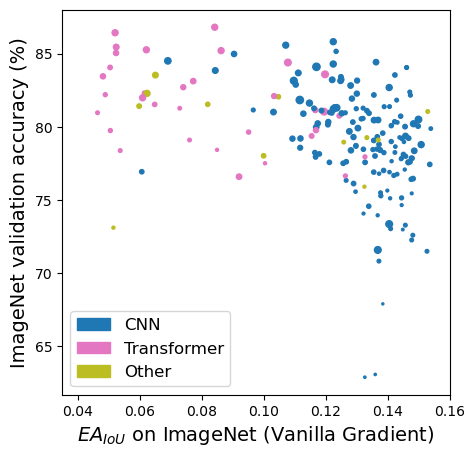

In [47]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.scatter(xs, ys, s = ss, c=cs)
ax.set_xlabel('$EA_{IoU}$ on ImageNet (Vanilla Gradient)', fontsize=14)
ax.set_ylabel('ImageNet validation accuracy (%)', fontsize=14)
ax.set_xlim(0.035,0.16)
blue_patch = mpatches.Patch(color=colors[0], label='CNN')
red_patch = mpatches.Patch(color=colors[6], label='Transformer')
green_patch = mpatches.Patch(color=colors[8], label='Other')

# Add legend
ax.legend(handles=[blue_patch, red_patch, green_patch], loc='lower left', fontsize=12)

In [48]:
xs = []
ys = []
cs = []
ss = []
for model_name in list(acc_dict.keys()):
    ys.append(acc_dict[model_name] * 100)
    xs.append(pg_dict[model_name])
    ss.append(math.sqrt(model_parameters[model_name]) / 500)
    if model_name in cnn_models:
        cs.append(colors[0])
    elif model_name in transformer_models:
        cs.append(colors[6])
    elif model_name in other_models:
        cs.append(colors[8])
    else:
        print (model_name)

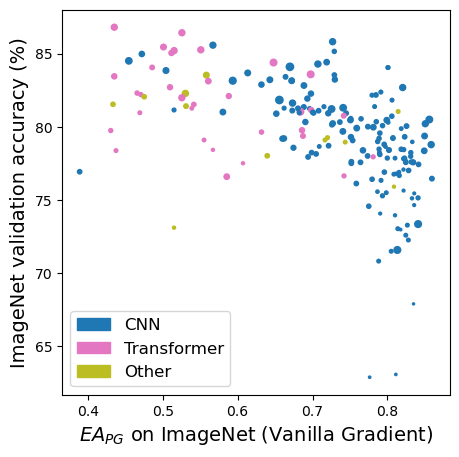

In [49]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.scatter(xs, ys, s = ss, c=cs)
ax.set_xlabel('$EA_{PG}$ on ImageNet (Vanilla Gradient)', fontsize=14)
ax.set_ylabel('ImageNet validation accuracy (%)', fontsize=14)

blue_patch = mpatches.Patch(color=colors[0], label='CNN')
red_patch = mpatches.Patch(color=colors[6], label='Transformer')
green_patch = mpatches.Patch(color=colors[8], label='Other')

# Add legend
ax.legend(handles=[blue_patch, red_patch, green_patch], loc='lower left', fontsize=12)

In [56]:
xs = []
ys = []
cs = []
ss = []
for model_name in list(acc_dict.keys()):
    ys.append(cifar_acc[model_name])
    xs.append(vg_dict[model_name])
    ss.append(math.sqrt(model_parameters[model_name]) / 500)
    if model_name in cnn_models:
        cs.append(colors[0])
    elif model_name in transformer_models:
        cs.append(colors[6])
    elif model_name in other_models:
        cs.append(colors[8])
    else:
        print (model_name)

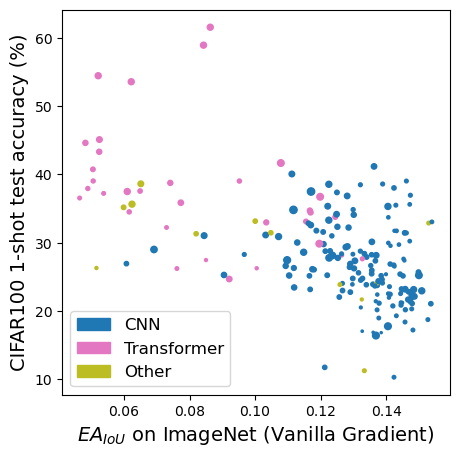

In [57]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.scatter(xs, ys, s = ss, c=cs)
ax.set_xlabel('$EA_{IoU}$ on ImageNet (Vanilla Gradient)', fontsize=14)
ax.set_ylabel('CIFAR100 1-shot test accuracy (%)', fontsize=14)

blue_patch = mpatches.Patch(color=colors[0], label='CNN')
red_patch = mpatches.Patch(color=colors[6], label='Transformer')
green_patch = mpatches.Patch(color=colors[8], label='Other')

# Add legend
ax.legend(handles=[blue_patch, red_patch, green_patch], loc='lower left', fontsize=12)

In [63]:
xs = []
ys = []
cs = []
ss = []

for model_name in list(gradcam_dict.keys()):
    ys.append(cifar_acc[model_name])
    xs.append(gradcam_dict[model_name])
    ss.append(math.sqrt(model_parameters[model_name]) / 500)
    cs.append(colors[0])

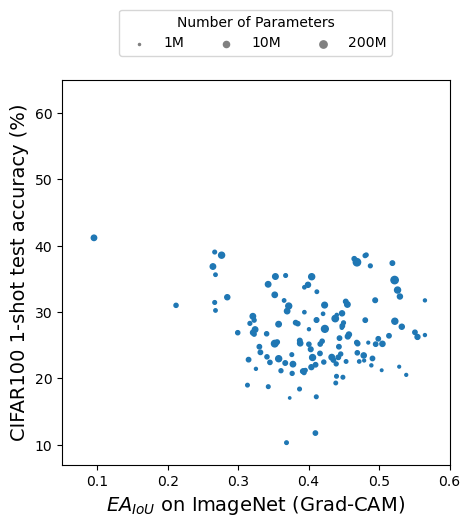

In [64]:
from matplotlib.lines import Line2D

fig, ax = plt.subplots(figsize=(5, 5))

sc = ax.scatter(xs, ys, s = ss, c=cs, label = "CNN")
ax.set_xlabel('$EA_{IoU}$ on ImageNet (Grad-CAM)', fontsize=14)
ax.set_ylabel('CIFAR100 1-shot test accuracy (%)', fontsize=14)
ax.set_ylim(7, 65)
ax.set_xlim(0.05,0.6)
blue_patch = mpatches.Patch(color=colors[0], label='CNN')

min_size = min(list(model_parameters.values()))
# print (min_size)
max_size = max(list(model_parameters.values()))
# print (max_size)
legend_sizes = np.linspace(min_size, max_size, 3)

def formate_label(value):
    # print (value)
    if value < 1419832:
        return '1M'
    elif value < 97973312.0:
        return '10M'
    else:
        return '200M'
    
handles = [plt.scatter([], [], s=size**0.5/500, color='gray', label=formate_label(size)) for size in legend_sizes]

ax.legend(handles=handles, title="Number of Parameters", loc='upper center', bbox_to_anchor=(0.5, 1.2), fontsize=10, ncol=3)
plt.show()